In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def load_knmi_data(filepath):
    """
    Load KNMI data from a file, convert units, and adjust timestamps.

    Args:
        filepath (str): Path to the KNMI data file.

    Returns:
        pd.DataFrame: Processed KNMI data with datetime in UTC and radiation in W/m², including other relevant columns.
    """
    columns_knmi = [
        'STN', 'YYYYMMDD', 'HH', 'DD', 'FH', 'FF', 'FX', 'T', 'T10N', 'TD',
        'SQ', 'Q', 'DR', 'RH', 'P', 'VV', 'N', 'U', 'WW', 'IX', 'M', 'R', 'S', 'O', 'Y'
    ]
    knmi_data = pd.read_csv(filepath, skiprows=52, names=columns_knmi, delimiter=',', skipinitialspace=True)

    # Convert `Q` from J/cm² to W/m²
    knmi_data['Q_Wm2'] = knmi_data['Q'] * 10000 / 3600

    # Create and adjust datetime to UTC
    knmi_data['datetime'] = pd.to_datetime(
        knmi_data['YYYYMMDD'].astype(str) + knmi_data['HH'].astype(str).str.zfill(2),
        format='%Y%m%d%H', errors='coerce'
    )
    knmi_data = knmi_data.dropna(subset=['datetime'])
    knmi_data['datetime'] = knmi_data['datetime'].dt.tz_localize('UTC')  # Explicitly set to UTC

    return knmi_data

def load_solcast_data(filepath):
    """
    Load Solcast data from a file.

    Args:
        filepath (str): Path to the Solcast data file.

    Returns:
        pd.DataFrame: Processed Solcast data with datetime and all columns.
    """
    solcast_data = pd.read_csv(filepath)

    # Convert to datetime
    solcast_data['datetime'] = pd.to_datetime(solcast_data['period_end'], format='%Y-%m-%dT%H:%M:%S%z', errors='coerce')
    solcast_data['datetime'] = solcast_data['datetime'].dt.tz_convert('UTC')  # Ensure datetime is in UTC

    return solcast_data

def plot_comparison(knmi_df, solcast_df, start_date, end_date):
    """
    Plot a comparison of KNMI and Solcast data for a given date range.

    Args:
        knmi_df (pd.DataFrame): Processed KNMI data.
        solcast_df (pd.DataFrame): Processed Solcast data.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
        None
    """
    # Merge datasets
    merged_data = pd.merge(knmi_df, solcast_df, on='datetime', how='inner')

    # Filter by date range
    filtered_data = merged_data[(merged_data['datetime'] >= start_date) & (merged_data['datetime'] < end_date)]

    # Plot
    plt.figure(figsize=(15, 7))
    plt.plot(filtered_data['datetime'], filtered_data['Q_Wm2'], label='KNMI (Q in W/m²)', alpha=0.7)
    plt.plot(filtered_data['datetime'], filtered_data['ghi'], label='Solcast (GHI in W/m²)', alpha=0.7)
    plt.xlabel('Datetime')
    plt.ylabel('Solar Irradiance (W/m²)')
    plt.title(f'Comparison of KNMI and Solcast Solar Radiation Data ({start_date} to {end_date})')
    plt.legend()
    plt.grid(True)
    plt.show()


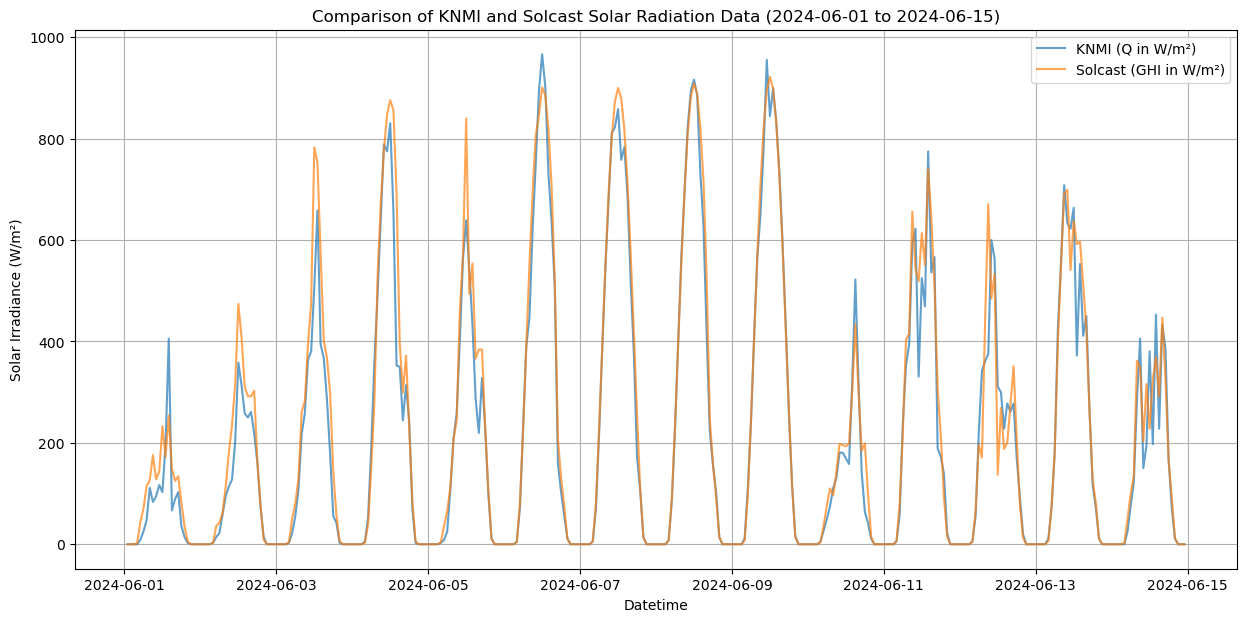

In [13]:
# Load KNMI and Solcast data
knmi_data = load_knmi_data('data/KNMI_weerdata.txt')
solcast_data = load_solcast_data('data/Solcast_data_2.csv')

plot_comparison(knmi_data, solcast_data, '2024-06-01', '2024-06-15')
